<p align="center">
  <img src="https://campus.fi.uba.ar/img/fiuba-footer-logo.png" height="180"/>
</p>

<p align="center">
<font size="+3">
[75.06] Organizacion de Datos - Curso Rodriguez
<br>
Trabajo Práctico 2 - Críticas cinematográficas
<br>
2024 1°C
<br>
Grupo 8
</font>
</p>
<br>

---

<br>
<font size="+2">
Integrantes
</font>
<br>
<font size="+1">
<ul align="center">
<li>Pratto, Federico Nicolas - 96.223</li>
<li>Testa, Santiago Tomas - 108.301</li>
</ul>
</font>

</p>

<br>
<br>

## Enunciado

El trabajo consiste en construir diferentes modelos de clasificación, capaces de analizar una porción de texto en lenguaje natural y detectar el sentimiento allí presente, al menos de forma binaria: positivo o negativo.

Para ello habrá que realizar un preprocesamiento del texto para que este pueda ser analizado por los distintos modelos. Se utilizará el modelo de **bag of words**, o cualquier otro que permita convertir texto en vectores.

Los modelos que se deben construir son los siguientes:

* Bayes Naïve
* Random Forest
* XGBoost
* Un modelo de red neuronal aplicando Keras y Tensor Flow.
* Un ensamble de al menos 3 modelos elegidos por el grupo.

Para cada uno de estos modelos se debe realizar una búsqueda de hiperparametros que optimicen su desempeño en el conjunto de test local (porción del archivo training).

Una vez encontrados dichos hiperparametros, se procederá a hacer un submit a Kaggle. Es decir que habrá al menos 5 submits (uno por cada modelo).

## Imports y carga de archivos

Importamos las librerias que vamos a utilizar.

In [2]:
# Manejo de datasets y Numpy
import pandas as pd
import numpy as np

# Bibliotecas para graficos
import matplotlib.pyplot as plt
import seaborn as sns

# **************************************************
# Usadas para Preprocesamiento
# **************************************************

# Bibliotecas para limpieza
!pip install unidecode
from unidecode import unidecode
import re

# Bibliotecas para eliminar reseñas en otros idiomas
!pip install langid
import langid

# Bibliotecas para Lematizacion
!python -m spacy download es_core_news_sm
!python -m spacy download es_core_news_md
import spacy

# Bibliotecas para tokenizacion
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Bibliotecas para eliminar stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')

# ********************
# Usadas para Modelos
# ********************

# Crear carpetas y chequear si existen archivos.
import os
from os.path import exists

# Dividir mis datasets de train.
from sklearn.model_selection import train_test_split

# Convertir el texto en una representación numérica
from sklearn.feature_extraction.text import TfidfVectorizer

# Hacer pipelines
from sklearn.pipeline import make_pipeline

# Guardar modelos
from joblib import dump, load

# Matriz de confusion y metricas
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report

# Busqueda de hiperparametros con RSCV y SKF
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb

# Red neuronal
# Dado que uno de los modulos que queriamos usar de TensorFlow no esta disponible en su ultima version
# optamos por instalar una version mas antigua de TensorFlow (2.12.0)

     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     --------------------------------------- 0.0/12.9 MB 660.6 kB/s eta 0:00:20
     --------------------------------------- 0.1/12.9 MB 657.6 kB/s eta 0:00:20
     ----- ---------------------------------- 1.8/12.9 MB 11.6 MB/s eta 0:00:01
     ---------------------- ----------------- 7.3/12.9 MB 35.7 MB/s eta 0:00:01
     --------------------------------- ---- 11.3/12.9 MB 110.0 MB/s eta 0:00:01
     --------------------------------- ---- 11.3/12.9 MB 110.0 MB/s eta 0:00:01
     --------------------------------- ---- 11.3/12.9 MB 110.0 MB/s eta 0:00:01
     --------------------------------- ---- 11.3/12.9 MB 110.0 MB/s eta 0:00:01
     --------------------------------- ---- 11.3/12.9 MB 110.0 MB/s eta 0:00:01
     ----------------------------------- --- 11.6/12.9 MB 31.2 MB/s eta 0:00:01
     --------------------------------------  12.9/12.9 M

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fprat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fprat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Instalo una version mas vieja de tensorflow
!pip uninstall tensorflow -y
!pip install tensorflow==2.12.0

In [3]:
# Chequeo la version de tensorflow
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


In [4]:
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Conecto mi drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defino la ruta donde voy a guardar/leer mis archivos

In [5]:
# Ruta donde van a estar todos nuestros archivos importantes
# ruta = "/content/drive/MyDrive/FIUBA/Organización de datos (75.06)/3. TPs/TP 2/"
ruta = ""

Creo las carpetas donde voy a almacenar mis archivos

In [6]:
# Solo si estoy trabajando localmente o en mi drive.
if ruta == "" or "/content/drive" in ruta:
    # Creo el directorio donde vamos a almacenar nuestros datasets procesados.
    os.makedirs(ruta + "datasets", exist_ok=True)

    # Creo el directorio donde vamos a almacenar nuestros modelos.
    os.makedirs(ruta + "modelos", exist_ok=True)

    # Creo el directorio donde vamos a almacenar nuestros resultados.
    os.makedirs(ruta + "resultados", exist_ok=True)

Importamos los datasets

In [5]:
df_train = pd.read_csv(ruta + "datasets/train.csv")
df_test = pd.read_csv(ruta + "datasets/test.csv")

## 1. Análisis Exploratorio y Preprocesamiento de Datos

El objetivo será explorar y preparar los datos para poder trabajar con los distintos modelos de aprendizaje automático.

Deben quedar unicamente aquellas criticas que esten en español.

#### 1.1. Analisis inicial

Comenzaremos haciendo un analisis inicial del contenido del dataset, asi como agrupando las variables segun su tipo.


In [ ]:
df_shape = df_train.shape
print(f"Nuestro dataset de entrenamiento esta compuesto por {df_shape[0]} publicaciones (filas) y {df_shape[1]} variables (columnas)")

df_shape = df_test.shape
print(f"Nuestro dataset de pruebas esta compuesto por {df_shape[0]} publicaciones (filas) y {df_shape[1]} variables (columnas)")

Nuestro dataset de entrenamiento esta compuesto por 50000 publicaciones (filas) y 3 variables (columnas)
Nuestro dataset de pruebas esta compuesto por 8599 publicaciones (filas) y 2 variables (columnas)


In [ ]:
df_train.info()
print("\n" + 40* "*" + "\n")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB

****************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


In [ ]:
df_train.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [ ]:
df_test.head()

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."


Como vemos, en el conjunto de train tengo 3 variables (ID, review_es y sentimiento) y en el de test tengo 2 variables (ID y review_es). Todas las variables son **cualitativas**

- `ID` (nominal): ID de la reseña.
- `review_es` (ordinal): Critica emitida.
- `sentimiento` (nominal): Sentimiento que expresa la critica.

#### 1.2. Eliminación de variables irrelevantes

Eliminamos la variable ID en el conjunto de train, dado que no cumple ninguna función.

No asi en el conjunto de test, dado que la necesitamos para la competencia de Kaggle

In [ ]:
df_train.drop(["ID"], axis=1, inplace = True)
df_train.head(5)

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


Guardamos el conjunto train para usarlo mas adelante

In [ ]:
# Le cambio el nombre a la columna review_es para que coincida con el que tendran las
# criticas en los otros dataset
df = df_train.copy()
df = df.rename(columns={'review_es': 'texto_codificado'})

# Solo si estoy trabajando localmente o en mi drive.
if ruta == "" or "/content/drive" in ruta:
    df.to_csv('datasets/train_reducido.csv', index=False)

del df

#### 1.3. Busqueda de valores nulos

Vamos a chequear si existen filas nuelas en nuestros datasets

In [ ]:
print("Datos nulos en el dataset de train:")
display(df_train.isnull().sum())

print("\nDatos nulos en el dataset de test:")
display(df_test.isnull().sum())

Datos nulos en el dataset de train:


review_es      0
sentimiento    0
dtype: int64


Datos nulos en el dataset de test:


ID           0
review_es    0
dtype: int64

Afortunadamente vemos que no existen valores nulos en nuestros datasets.

#### 1.4. Limpieza general

Realizamos una limpieza general de nuestro texto a fin de eliminar carateres especiales, no alfabeticos, mayusculas, etc.

In [ ]:
from unicodedata import normalize

# Esta funcion elimina los diacriticos pero sin afectar a las ñ
# (Fuente: https://es.stackoverflow.com/questions/135707/c%C3%B3mo-puedo-reemplazar-las-letras-con-tildes-por-las-mismas-sin-tilde-pero-no-l)
def eliminar_diacriticos(texto):
    # -> NFD y eliminar diacríticos
    texto_corregido = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1",
        normalize( "NFD", texto), 0, re.I
    )

    # -> NFC
    texto_corregido = normalize( 'NFC', texto_corregido)

    return texto_corregido


def limpiar_texto(texto):
  # Convertimos el texto a minúsculas.
  texto_limpio = texto.lower()

  # Eliminamos los diacríticos
  texto_limpio = eliminar_diacriticos(texto_limpio)

  # Reemplazamos los signos de puntuación por espacios
  texto_limpio = re.sub(r'[.,:;!?]', ' ', texto_limpio)

  # Dejamos únicamente los caracteres alfabéticos, espacios y la letra "ñ".
  texto_limpio = re.sub(r'[^\w\sñ]', '', texto_limpio)

  # Eliminamos las palabras que tengan un único caracter
  texto_limpio = re.sub(r'\b[a-zñ]\b', '', texto_limpio)

  # Sustituimos los espacios en blanco multiples por un unico espacio.
  texto_limpio = re.sub(r'\s+', ' ', texto_limpio, flags=re.I)

  return texto_limpio

In [ ]:
# Limpiamos el texto y mostramos el resultado.
df_train["texto_codificado"] = df_train["review_es"].apply(limpiar_texto)
df_train["texto_codificado"].head(5)

0    uno de los otros criticos ha mencionado que de...
1    una pequeña pequeña produccion la tecnica de f...
2    pense que esta era una manera maravillosa de p...
3    basicamente hay una familia donde un niño pequ...
4    el amor en el tiempo de petter mattei es una p...
Name: texto_codificado, dtype: object

#### 1.5. Eliminar reseñar en otros idiomas

In [ ]:
def detectar_idioma(texto):
  return langid.classify(texto)[0]

In [ ]:
# Detectamos en que idioma esta cada reseña.
df_train["idioma_de_la_critica"] = df_train["review_es"].apply(detectar_idioma)

# Mostramos cuantas criticas estan en otro idioma
cantidad_en_otro_idioma = df_train[df_train["idioma_de_la_critica"] != "es"].shape[0]
print("Cantidad de críticas que no están en español:", cantidad_en_otro_idioma)

# Eliminamos las filas que no están en español
df_train = df_train[df_train["idioma_de_la_critica"] == "es"]

# Eliminamos la columna temporal "idioma_de_la_critica"
del df_train["idioma_de_la_critica"]

Cantidad de críticas que no están en español: 1821


Exporto el dataset preprocesado hasta este punto.

In [ ]:
# Eliminamos la columna review_es que ya no la vamos a usar.
df_train.drop("review_es", axis=1, inplace=True)

# Solo si estoy trabajando localmente o en mi drive.
if ruta == "" or "/content/drive" in ruta:
    # Guardamos el dataset filtrado hasta ahora.
    df_train.to_csv(ruta + "datasets/train_limpio.csv", index=False)

#### 1.6. Lematización

La lematización es el proceso de reducir las palabras a su forma base o "lema", lo que ayuda a agrupar las palabras que tienen la misma raíz, incluso si están conjugadas o tienen diferentes formas gramaticales.

In [ ]:
# Funcion para lematizar textos.
def lematizar_texto(texto):

  # Inicializamos Spacy con modelos en español
  nlp = spacy.load("es_core_news_md")

  # Procesar el texto con spaCy
  doc = nlp(texto)

  # Extraer lemas y filtrar palabras vacías
  lemas = [token.lemma_ for token in doc if not token.is_stop]

  # Unir los lemas en una cadena de texto
  texto_lematizado = ' '.join(lemas)

  return texto_lematizado

Lematizamos el texto y mostramos los resultados obtenidos

In [ ]:
df_train["texto_codificado"] = df_train["texto_codificado"].apply(lematizar_texto)
df_train["texto_codificado"].head(5)

0    critico mencionar 1 oz episodio estar engancha...
1    pequeño pequeño produccion tecnica filmacion i...
2    pensir maravilloso pasar tiempo semana verano ...
3    basicamente familia niño pequeño jake pensar z...
4    amor tiempo petter mattei pelicula visualmente...
Name: texto_codificado, dtype: object

Exporto el dataset preprocesado hasta este punto.

In [ ]:
# Solo si estoy trabajando localmente o en mi drive.
if ruta == "" or "/content/drive" in ruta:
    df_train.to_csv(ruta + "datasets/train_lematizado.csv", index=False)

#### 1.7. Tokenización y eliminacion de Stopwords

La tokenización es el proceso de dividir un texto en unidades más pequeñas, como palabras o caracteres, para facilitar su análisis y procesamiento por parte de una computadora.

De esta seccion vamos a obtener dos datasets tokenizados. Uno basado en el dataset que previamente hemos lematizado y otro basado en el dataset sin lematizar.

In [ ]:
def tokenizar_y_limpiar_texto(texto):
  # Usamos stop words del español
  stop_words = set(stopwords.words("spanish"))

  # tokenizamos el texto para poder eliminar las stopwords
  texto_tokenizado = word_tokenize(texto)

  # filtramos las stopwords.
  texto_tokenizado_y_filtrado = [palabra for palabra in texto_tokenizado if palabra not in stop_words]

  return texto_tokenizado_y_filtrado

##### 1.7.1. Tokenización del conjunto sin lematizar

Cargamos el dataset sin lematizar

In [ ]:
df_train = pd.read_csv(ruta + "datasets/train_limpio.csv")

Eliminamos las stopwords y mostramos el resultado

In [ ]:
df_train["texto_codificado"] = df_train["texto_codificado"].apply(tokenizar_y_limpiar_texto)
df_train["texto_codificado"].head(5)

0    [criticos, mencionado, despues, ver, solo, 1, ...
1    [pequeña, pequeña, produccion, tecnica, filmac...
2    [pense, manera, maravillosa, pasar, tiempo, fi...
3    [basicamente, familia, niño, pequeño, jake, pi...
4    [amor, tiempo, petter, mattei, pelicula, visua...
Name: texto_codificado, dtype: object

Exporto el dataset preprocesado hasta este punto.

In [ ]:
# Solo si estoy trabajando localmente o en mi drive.
if ruta == "" or "/content/drive" in ruta:
    df_train.to_csv(ruta + "datasets/train_tokenizado.csv", index=False)

##### 1.7.2. Tokenización del conjunto lematizado

Cargamos el dataset lematizado

In [ ]:
df_train = pd.read_csv(ruta + "datasets/train_lematizado.csv")

Eliminamos las stopwords y mostramos el resultado

In [ ]:
df_train["texto_codificado"] = df_train["texto_codificado"].apply(tokenizar_y_limpiar_texto)
df_train["texto_codificado"].head(5)

0    [critico, mencionar, 1, oz, episodio, engancha...
1    [pequeño, pequeño, produccion, tecnica, filmac...
2    [pensir, maravilloso, pasar, tiempo, semana, v...
3    [basicamente, familia, niño, pequeño, jake, pe...
4    [amor, tiempo, petter, mattei, pelicula, visua...
Name: texto_codificado, dtype: object

Exporto el dataset preprocesado hasta este punto.

In [ ]:
# Solo si estoy trabajando localmente o en mi drive.
if ruta == "" or "/content/drive" in ruta:
    df_train.to_csv(ruta + "datasets/train_final.csv", index=False)

## 2. Modelos

#### 2.1. Preparación

In [6]:
# Hago un listado de mis datasets para probarlos todos contra mis modelos.
datasets_train = ["train_reducido", "train_limpio","train_lematizado", "train_tokenizado", "train_final"]

# Vuelvo a cargar el dataset de test por las dudas
df_test = pd.read_csv(ruta + "datasets/test.csv")

"""
* train_reducido ==> Dataset base, se le elimino la columna ID y la columna review_es se reemplazo por texto_codificado
* train_limpio ==> Se formateo el texto y se eliminaron las criticas en otros idiomas.
* train_lematizado ==> Se partio de train_limpio y se lematizo el texto.
* train_tokenizado ==> Se partio de train_limpio y se tokenizo el texto y se eliminaron las stopwords
* train_final ==> Se partio de train_lematizado y se tokenizo el texto y se eliminaron las stopwords
"""

'\n* train_reducido ==> Dataset base, se le elimino la columna ID y la columna review_es se reemplazo por texto_codificado\n* train_limpio ==> Se formateo el texto y se eliminaron las criticas en otros idiomas.\n* train_lematizado ==> Se partio de train_limpio y se lematizo el texto.\n* train_tokenizado ==> Se partio de train_limpio y se tokenizo el texto y se eliminaron las stopwords\n* train_final ==> Se partio de train_lematizado y se tokenizo el texto y se eliminaron las stopwords\n'

In [7]:
# Funcion para mostrar las metricas de mi modelo y la matriz de confusion
def mostrar_metricas(y_test, y_pred, dataset):

  # Muestro el dataset con el que estoy trabajando
  print(f"Metricas obtenidas con el dataset: {dataset}\n")

  # Calculo y muestro las metricas obtenidas.
  print(classification_report(y_test, y_pred))

  # Calculo la matriz de confusión
  matriz = confusion_matrix(y_test, y_pred)

  # Ploteo la matriz de confusion
  sns.heatmap(matriz, cmap="Blues", annot=True, fmt='g')
  plt.xlabel("Predicho")
  plt.ylabel("Real")
  plt.show()

  # Separador
  print("\n" + 40 * "*" + "\n")

In [8]:
# Funcion creada para cargar el dataset solicitado y crear el split test.
def generar_datos_para_test(nombre_dataset):

  # Cargo el dataset ya preprocesado
  ruta_dataset = ruta + "datasets/" + nombre_dataset + ".csv"
  df_train = pd.read_csv(ruta_dataset)

  # Separo mis caracteristicas.
  df_train_x = df_train.copy()
  df_train_x.drop("sentimiento", axis=1, inplace=True)
  df_train_y = df_train["sentimiento"].copy()

  x_train, x_test, y_train, y_test = train_test_split(df_train_x,
                                                      df_train_y,
                                                      test_size = 0.30,
                                                      random_state = 9,
                                                      shuffle = True
                                                      )
  return x_train, x_test, y_train, y_test

### 2.2. Modelo 1 - Bayes Naïve

Vease el archivo -> 7506R_TP2_GRUPO08_CHP1_ENTREGA_N2.ipynb

### 2.3. Modelo 2 - Random Forest

#### 2.3.1. Random Forest basico

Comenzamos entrenando un modelo sin buscar los mejores hiperparametros para ver que obtenemos.

Metricas obtenidas con el dataset: train_reducido

              precision    recall  f1-score   support

    negativo       0.82      0.84      0.83      7525
    positivo       0.83      0.82      0.83      7475

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



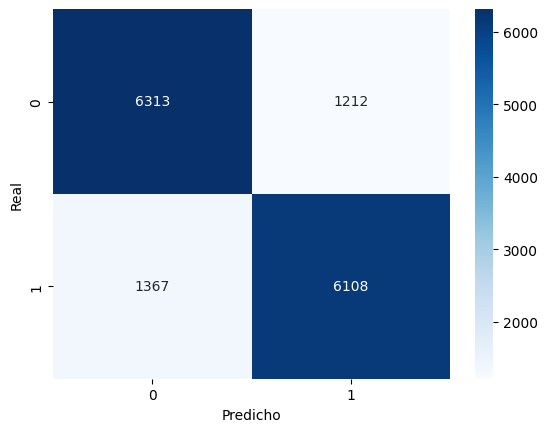


****************************************

Metricas obtenidas con el dataset: train_limpio

              precision    recall  f1-score   support

    negativo       0.82      0.86      0.84      7168
    positivo       0.85      0.82      0.83      7286

    accuracy                           0.84     14454
   macro avg       0.84      0.84      0.84     14454
weighted avg       0.84      0.84      0.84     14454



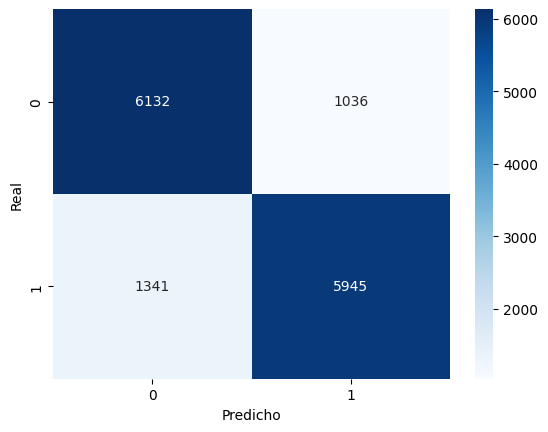


****************************************

Metricas obtenidas con el dataset: train_lematizado

              precision    recall  f1-score   support

    negativo       0.82      0.86      0.84      7168
    positivo       0.86      0.82      0.84      7286

    accuracy                           0.84     14454
   macro avg       0.84      0.84      0.84     14454
weighted avg       0.84      0.84      0.84     14454



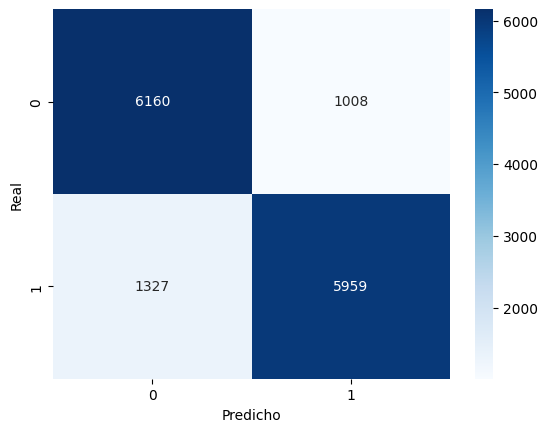


****************************************

Metricas obtenidas con el dataset: train_tokenizado

              precision    recall  f1-score   support

    negativo       0.83      0.87      0.85      7168
    positivo       0.86      0.82      0.84      7286

    accuracy                           0.84     14454
   macro avg       0.84      0.84      0.84     14454
weighted avg       0.84      0.84      0.84     14454



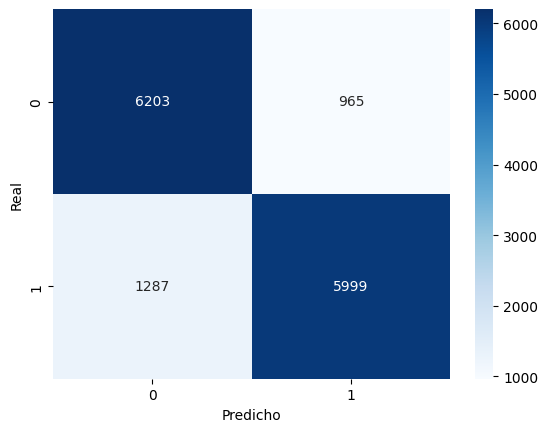


****************************************

Metricas obtenidas con el dataset: train_final

              precision    recall  f1-score   support

    negativo       0.83      0.85      0.84      7168
    positivo       0.85      0.83      0.84      7286

    accuracy                           0.84     14454
   macro avg       0.84      0.84      0.84     14454
weighted avg       0.84      0.84      0.84     14454



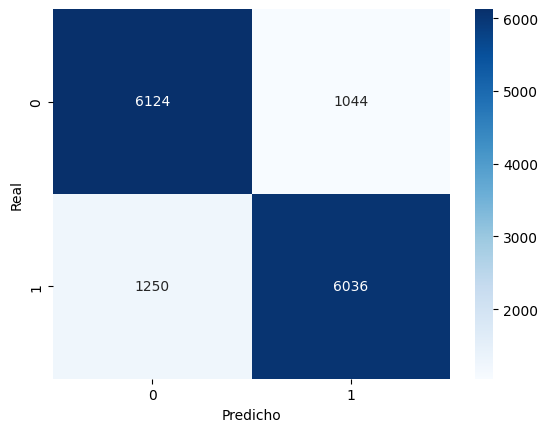


****************************************



In [ ]:
for dataset in datasets_train:

  # Cargo los datos para entrenar mi modelo
  x_train_rf, x_test_rf, y_train_rf, y_test_rf = generar_datos_para_test(dataset)

  # Creamos el modelo
  modelo_rf = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=23))

  # Entrenamos el modelo
  modelo_rf.fit(x_train_rf.texto_codificado, y_train_rf)

  # Predecimos con el modelo contra el set que me arme de pruebas
  y_pred_rf = modelo_rf.predict(x_test_rf.texto_codificado)

  # Mostramos los resultados obtenidos.
  mostrar_metricas(y_test_rf, y_pred_rf, dataset)

  # Predecimos con el modelo contra el set de pruebas que nos dieron.
  y_pred_rf = modelo_rf.predict(df_test.review_es)

  # Guardamos los resultados obtenidos
  ds_resultados = pd.DataFrame({'id': df_test["ID"], "sentimiento": y_pred_rf})
  ruta_resultados = ruta + "resultados/" + "resultados_rf_basico_" + dataset + ".csv"

  # Solo si estoy trabajando localmente o en mi drive.
  if ruta == "" or "/content/drive" in ruta:
    ds_resultados.to_csv(ruta_resultados, index=False)

  # Guardamos el modelo entrenado
  ruta_modelo = ruta + "modelos/" + "modelo_rf_basico_" + dataset + ".joblib"

  # Solo si estoy trabajando localmente o en mi drive.
  if ruta == "" or "/content/drive" in ruta:
    dump(modelo_rf, ruta_modelo)

#### 2.3.2. Random Forest con mejores hiperparametros

Buscamos los mejores hiperparametros para cada dataset que obtuvimos al realizar el preprocesado.

In [ ]:
# Diccionario donde voy a guardar los mejores parametros.
mejores_parametros_rf = {}

for dataset in datasets_train:

  # Cargo los datos para entrenar mi modelo
  x_train_rf, x_test_rf, y_train_rf, y_test_rf = generar_datos_para_test(dataset)

  # Define el número de iteraciones y la cantidad de splits para la validación cruzada
  n = 10
  cantidad_folds = 5

  # Define la grilla de parámetros
  grilla_de_parametros_rf = {
    "randomforestclassifier__n_estimators": [50, 100],
    "randomforestclassifier__criterion": ["gini", "entropy"],
    "randomforestclassifier__min_samples_split": [40, 50],
    "randomforestclassifier__min_samples_leaf": [15, 30],

    "tfidfvectorizer__min_df": [0.01, 0.05, 0.1],
    "tfidfvectorizer__max_df": [0.3, 0.5],
    "tfidfvectorizer__max_features": [1000, 2000, None]
  }


  # Define el modelo de clasificación XGBoost
  modelo_rf = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=23))

  # Define el objeto de validación cruzada estratificada
  skf = StratifiedKFold(n_splits=cantidad_folds, shuffle=True, random_state=23)

  # Define la búsqueda aleatoria de hiperparámetros
  randomcv = RandomizedSearchCV(estimator=modelo_rf,
                                param_distributions=grilla_de_parametros_rf,
                                scoring='f1',  # Utiliza la métrica F1 Score para optimizar.
                                cv = skf,
                                n_jobs=-1,
                                n_iter=n,
                                random_state=23)

  # Entrena el modelo de búsqueda aleatoria de hiperparámetros
  randomcv.fit(x_train_rf.texto_codificado, y_train_rf)

  # Imprime la mejor métrica y los mejores parámetros encontrados
  print(f"\nMejores parametros en Random Forest para el datasets: {dataset}\n")
  print("Mejor precisión:", randomcv.best_score_)
  mejores_parametros_rf[dataset] = randomcv.best_params_
  print("Mejores parámetros:", mejores_parametros_rf[dataset])
  print("\n******************************************\n")

c:\Users\fprat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



Mejores parametros en Random Forest para el datasets: train_reducido

Mejor precisión: nan
Mejores parámetros: {'tfidfvectorizer__min_df': 0.05, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__max_df': 0.5, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__min_samples_split': 50, 'randomforestclassifier__min_samples_leaf': 15, 'randomforestclassifier__criterion': 'gini'}

******************************************



c:\Users\fprat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



Mejores parametros en Random Forest para el datasets: train_limpio

Mejor precisión: nan
Mejores parámetros: {'tfidfvectorizer__min_df': 0.05, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__max_df': 0.5, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__min_samples_split': 50, 'randomforestclassifier__min_samples_leaf': 15, 'randomforestclassifier__criterion': 'gini'}

******************************************



c:\Users\fprat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



Mejores parametros en Random Forest para el datasets: train_lematizado

Mejor precisión: nan
Mejores parámetros: {'tfidfvectorizer__min_df': 0.05, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__max_df': 0.5, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__min_samples_split': 50, 'randomforestclassifier__min_samples_leaf': 15, 'randomforestclassifier__criterion': 'gini'}

******************************************



c:\Users\fprat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



Mejores parametros en Random Forest para el datasets: train_tokenizado

Mejor precisión: nan
Mejores parámetros: {'tfidfvectorizer__min_df': 0.05, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__max_df': 0.5, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__min_samples_split': 50, 'randomforestclassifier__min_samples_leaf': 15, 'randomforestclassifier__criterion': 'gini'}

******************************************



c:\Users\fprat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



Mejores parametros en Random Forest para el datasets: train_final

Mejor precisión: nan
Mejores parámetros: {'tfidfvectorizer__min_df': 0.05, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__max_df': 0.5, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__min_samples_split': 50, 'randomforestclassifier__min_samples_leaf': 15, 'randomforestclassifier__criterion': 'gini'}

******************************************



Ahora que ya tenemos los mejores parametros procedemos a armar nuestro modelo y ponerlo a prueba para cada uno de nuestros datasets

Metricas obtenidas con el dataset: train_reducido

              precision    recall  f1-score   support

    negativo       0.78      0.77      0.77      7525
    positivo       0.77      0.78      0.78      7475

    accuracy                           0.77     15000
   macro avg       0.77      0.77      0.77     15000
weighted avg       0.77      0.77      0.77     15000



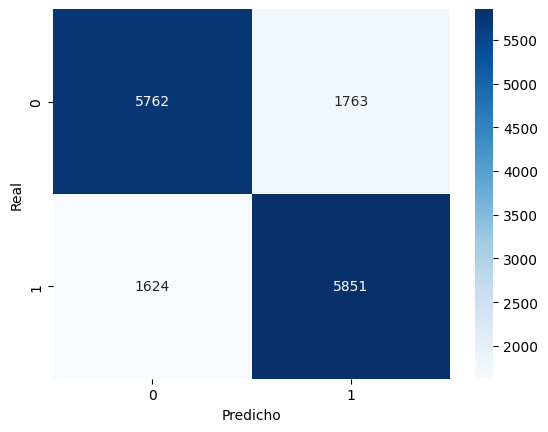


****************************************

Metricas obtenidas con el dataset: train_limpio

              precision    recall  f1-score   support

    negativo       0.77      0.79      0.78      7168
    positivo       0.79      0.77      0.78      7286

    accuracy                           0.78     14454
   macro avg       0.78      0.78      0.78     14454
weighted avg       0.78      0.78      0.78     14454



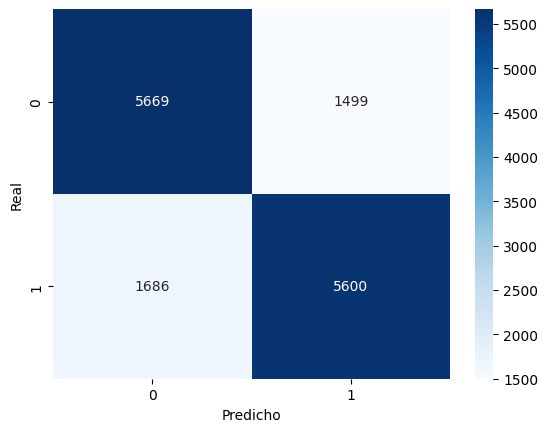


****************************************

Metricas obtenidas con el dataset: train_lematizado

              precision    recall  f1-score   support

    negativo       0.77      0.78      0.78      7168
    positivo       0.79      0.77      0.78      7286

    accuracy                           0.78     14454
   macro avg       0.78      0.78      0.78     14454
weighted avg       0.78      0.78      0.78     14454



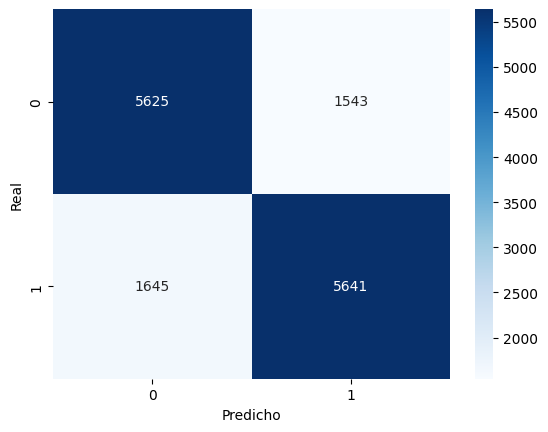


****************************************

Metricas obtenidas con el dataset: train_tokenizado

              precision    recall  f1-score   support

    negativo       0.77      0.78      0.78      7168
    positivo       0.78      0.77      0.78      7286

    accuracy                           0.78     14454
   macro avg       0.78      0.78      0.78     14454
weighted avg       0.78      0.78      0.78     14454



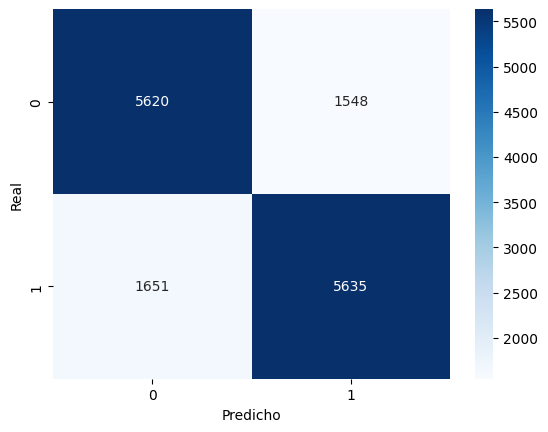


****************************************

Metricas obtenidas con el dataset: train_final

              precision    recall  f1-score   support

    negativo       0.78      0.78      0.78      7168
    positivo       0.79      0.78      0.78      7286

    accuracy                           0.78     14454
   macro avg       0.78      0.78      0.78     14454
weighted avg       0.78      0.78      0.78     14454



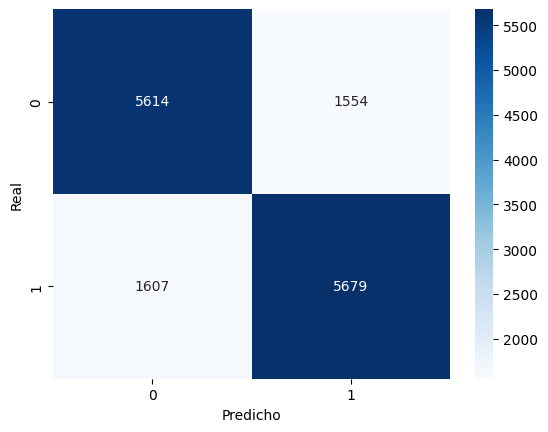


****************************************



In [ ]:
for dataset in datasets_train:

  # Cargo los datos para entrenar mi modelo
  x_train_rf, x_test_rf, y_train_rf, y_test_rf = generar_datos_para_test(dataset)

  # Separo los mejores parametros
  mejores_parametros = mejores_parametros_rf[dataset]
  parametros_rf = {key: value for key, value in mejores_parametros.items() if key.startswith('xgbclassifier__')}
  parametros_tfidf = {key.replace('tfidfvectorizer__', ''): value for key, value in mejores_parametros.items() if key.startswith('tfidfvectorizer__')}

  # Creamos el modelo (Tuve que asignarle los parametros "a mano" a xgb porque no los tomaba con set_params)
  modelo_rf = make_pipeline(TfidfVectorizer(**parametros_tfidf),
                            RandomForestClassifier(random_state=23).set_params(**parametros_rf)
                            )

  # Entrenamos el modelo
  modelo_rf.fit(x_train_rf.texto_codificado, y_train_rf)

  # Realizamos la predicción
  y_pred_rf = modelo_rf.predict(x_test_rf.texto_codificado)

  # Mostramos los resultados obtenidos.
  mostrar_metricas(y_test_rf, y_pred_rf, dataset)

  # Predecimos con el modelo contra el set de pruebas que nos dieron.
  y_pred_rf = modelo_rf.predict(df_test.review_es)

  # Guardamos los resultados obtenidos
  ds_resultados = pd.DataFrame({'id': df_test["ID"], "sentimiento": y_pred_rf})
  ruta_resultados = ruta + "resultados/" + "resultados_rf_optimizado_" + dataset + ".csv"

  # Solo si estoy trabajando localmente o en mi drive.
  if ruta == "" or "/content/drive" in ruta:
    ds_resultados.to_csv(ruta_resultados, index=False)

  # Guardamos el modelo entrenado
  ruta_modelo = ruta + "modelos/" + "modelo_rf_optimizado_" + dataset + ".joblib"

  # Solo si estoy trabajando localmente o en mi drive.
  if ruta == "" or "/content/drive" in ruta:
    dump(modelo_rf, ruta_modelo)

### 2.4. Modelo 3 - XGBoost

#### 2.4.1. XGBoost basico

Comenzamos entrenando un modelo sin buscar los mejores hiperparametros para ver que obtenemos.

Metricas obtenidas con el dataset: train_reducido

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      7475
           1       0.85      0.82      0.83      7525

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



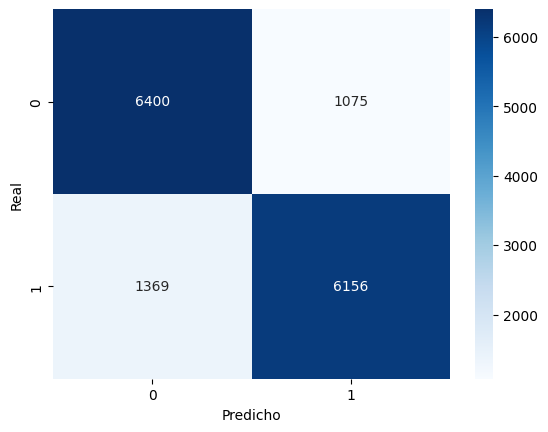


****************************************

Metricas obtenidas con el dataset: train_limpio

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      7286
           1       0.85      0.83      0.84      7168

    accuracy                           0.84     14454
   macro avg       0.84      0.84      0.84     14454
weighted avg       0.84      0.84      0.84     14454



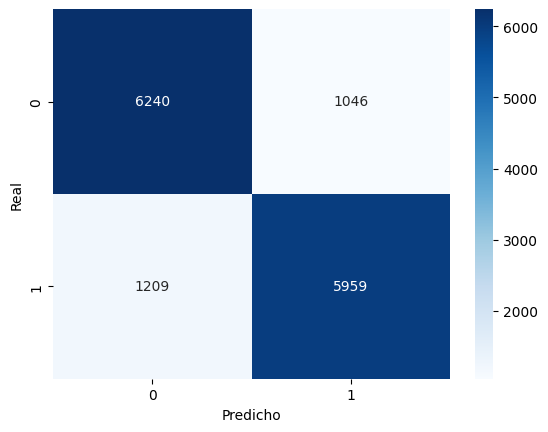


****************************************

Metricas obtenidas con el dataset: train_lematizado

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      7286
           1       0.85      0.83      0.84      7168

    accuracy                           0.84     14454
   macro avg       0.84      0.84      0.84     14454
weighted avg       0.84      0.84      0.84     14454



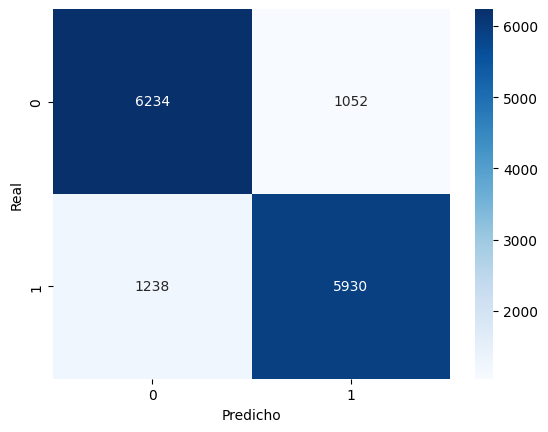


****************************************

Metricas obtenidas con el dataset: train_tokenizado

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      7286
           1       0.86      0.83      0.84      7168

    accuracy                           0.84     14454
   macro avg       0.85      0.84      0.84     14454
weighted avg       0.85      0.84      0.84     14454



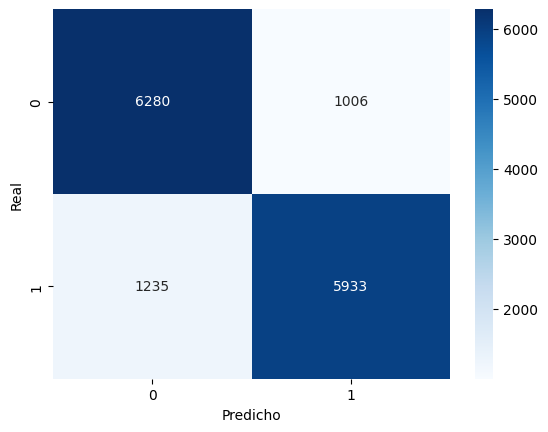


****************************************

Metricas obtenidas con el dataset: train_final

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      7286
           1       0.85      0.82      0.83      7168

    accuracy                           0.84     14454
   macro avg       0.84      0.84      0.84     14454
weighted avg       0.84      0.84      0.84     14454



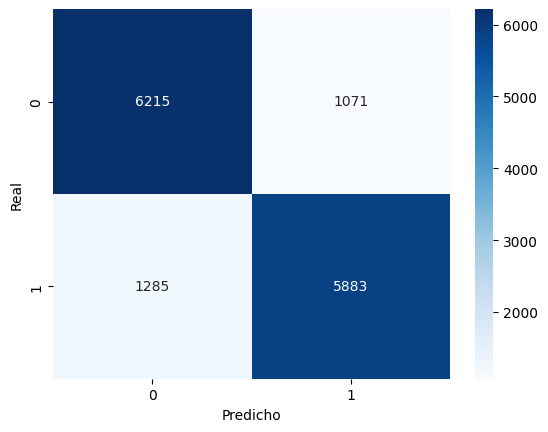


****************************************



In [ ]:
for dataset in datasets_train:

  # Cargo los datos para entrenar mi modelo
  x_train_xgb, x_test_xgb, y_train_xgb, y_test_xgb = generar_datos_para_test(dataset)

  # La implementación que usamos de XGBoost no soporta las etiquetas positivo/negativo, asi que las transformamos en 1 y 0.
  y_train_xgb = y_train_xgb.map(lambda x: 1 if x == 'negativo' else 0)
  y_test_xgb = y_test_xgb.map(lambda x: 1 if x == 'negativo' else 0)

  # Creamos el modelo
  modelo_xgb = make_pipeline(TfidfVectorizer(), xgb.XGBClassifier(random_state=23))

  # Entrenamos el modelo
  modelo_xgb.fit(x_train_xgb.texto_codificado, y_train_xgb)

  # Predecimos con el modelo contra el set que me arme de pruebas
  y_pred_xgb = modelo_xgb.predict(x_test_xgb.texto_codificado)

  # Mostramos los resultados obtenidos.
  mostrar_metricas(y_test_xgb, y_pred_xgb, dataset)

  # Predecimos con el modelo contra el set de pruebas que nos dieron.
  y_pred_xgb = modelo_xgb.predict(df_test.review_es)

  # Guardamos los resultados obtenidos
  ds_resultados = pd.DataFrame({'id': df_test["ID"], "sentimiento": y_pred_xgb})
  ds_resultados["sentimiento"] = ds_resultados["sentimiento"].map({0: "positivo", 1: "negativo"})
  ruta_resultados = ruta + "resultados/" + "resultados_xgb_basico_" + dataset + ".csv"

  # Solo si estoy trabajando localmente o en mi drive.
  if ruta == "" or "/content/drive" in ruta:
    ds_resultados.to_csv(ruta_resultados, index=False)

  # Guardamos el modelo entrenado
  ruta_modelo = ruta + "modelos/" + "modelo_xgb_basico_" + dataset + ".joblib"

  # Solo si estoy trabajando localmente o en mi drive.
  if ruta == "" or "/content/drive" in ruta:
    dump(modelo_xgb, ruta_modelo)

#### 2.4.2. XGBoost con mejores hiperparametros

Buscamos los mejores hiperparametros para cada dataset que obtuvimos al realizar el preprocesado.

In [ ]:
# Diccionario donde voy a guardar los mejores parametros.
mejores_parametros_xgb = {}

for dataset in datasets_train:

  # Cargo los datos para entrenar mi modelo
  x_train_xgb, x_test_xgb, y_train_xgb, y_test_xgb = generar_datos_para_test(dataset)

  # La implementación que usamos de XGBoost no soporta las etiquetas positivo/negativo, asi que las transformamos en 1 y 0.
  y_train_xgb = y_train_xgb.map(lambda x: 1 if x == 'negativo' else 0)
  y_test_xgb = y_test_xgb.map(lambda x: 1 if x == 'negativo' else 0)

  # Define el número de iteraciones y la cantidad de splits para la validación cruzada
  n = 10
  cantidad_folds = 5

  # Define la grilla de parámetros
  grilla_de_parametros_xgb = {
    'tfidfvectorizer__max_df': [0.9, 0.95, 0.98],
    'tfidfvectorizer__min_df': [0.03, 0.05, 0.07],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2)],
    'xgbclassifier__n_estimators': [50, 100, 150, 200],
    'xgbclassifier__max_depth': [5, 6, 7, 8, 9, 10],
    'xgbclassifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'xgbclassifier__reg_alpha': [0, 0.001],
    'xgbclassifier__reg_lambda': [0, 0.001]
  }

  # Define el modelo de clasificación XGBoost
  modelo_xgb = make_pipeline(TfidfVectorizer(), xgb.XGBClassifier(random_state=23))

  # Define el objeto de validación cruzada estratificada
  skf = StratifiedKFold(n_splits=cantidad_folds, shuffle=True, random_state=23)

  # Define la búsqueda aleatoria de hiperparámetros
  randomcv = RandomizedSearchCV(estimator=modelo_xgb,
                                param_distributions=grilla_de_parametros_xgb,
                                scoring='f1',  # Utiliza la métrica F1 Score para optimizar.
                                cv = skf,
                                n_jobs=-1,
                                n_iter=n,
                                random_state=23)

  # Entrena el modelo de búsqueda aleatoria de hiperparámetros
  randomcv.fit(x_train_xgb.texto_codificado, y_train_xgb)

  # Imprime la mejor métrica y los mejores parámetros encontrados
  print(f"\nMejores parametros en XGB para el datasets: {dataset}\n")
  print("Mejor precisión:", randomcv.best_score_)
  mejores_parametros_xgb[dataset] = randomcv.best_params_
  print("Mejores parámetros:", mejores_parametros_xgb[dataset])
  print("\n******************************************\n")


Mejores parametros en XGB para el datasets: train_reducido

Mejor precisión: 0.8124653584179473
Mejores parámetros: {'xgbclassifier__reg_lambda': 0, 'xgbclassifier__reg_alpha': 0.001, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__max_depth': 6, 'xgbclassifier__learning_rate': 0.2, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__min_df': 0.03, 'tfidfvectorizer__max_df': 0.95}

******************************************


Mejores parametros en XGB para el datasets: train_limpio

Mejor precisión: 0.8238851142250375
Mejores parámetros: {'xgbclassifier__reg_lambda': 0, 'xgbclassifier__reg_alpha': 0.001, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__max_depth': 6, 'xgbclassifier__learning_rate': 0.2, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__min_df': 0.03, 'tfidfvectorizer__max_df': 0.95}

******************************************


Mejores parametros en XGB para el datasets: train_lematizado

Mejor precisión: 0.8015643284982827
Mejores parámetros: {'x

Ahora que ya tenemos los mejores parametros procedemos a armar nuestro modelo y ponerlo a prueba para cada uno de nuestros datasets

Metricas obtenidas con el dataset: train_reducido

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      7475
           1       0.83      0.80      0.82      7525

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000



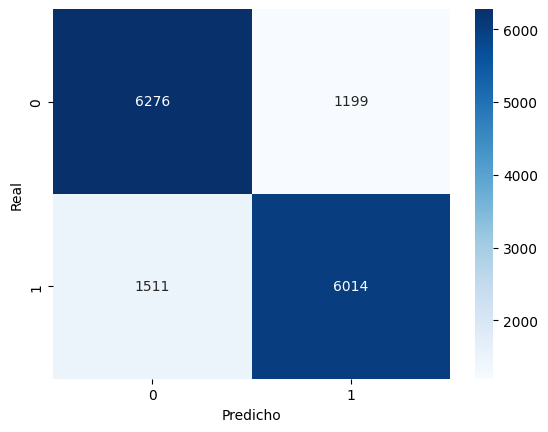


****************************************

Metricas obtenidas con el dataset: train_limpio

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      7286
           1       0.83      0.82      0.83      7168

    accuracy                           0.83     14454
   macro avg       0.83      0.83      0.83     14454
weighted avg       0.83      0.83      0.83     14454



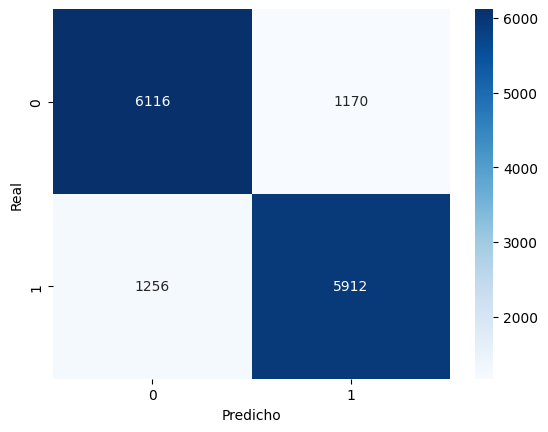


****************************************

Metricas obtenidas con el dataset: train_lematizado

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      7286
           1       0.81      0.80      0.81      7168

    accuracy                           0.81     14454
   macro avg       0.81      0.81      0.81     14454
weighted avg       0.81      0.81      0.81     14454



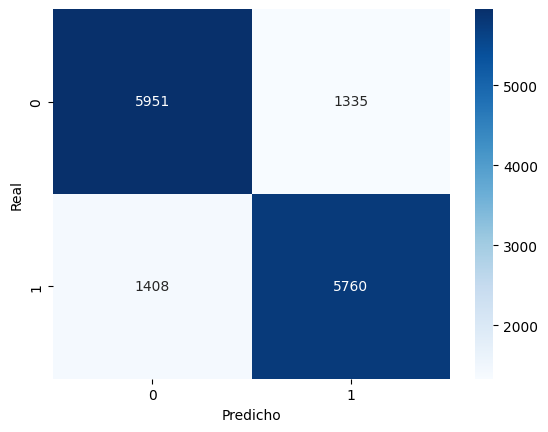


****************************************

Metricas obtenidas con el dataset: train_tokenizado

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      7286
           1       0.83      0.80      0.81      7168

    accuracy                           0.82     14454
   macro avg       0.82      0.82      0.82     14454
weighted avg       0.82      0.82      0.82     14454



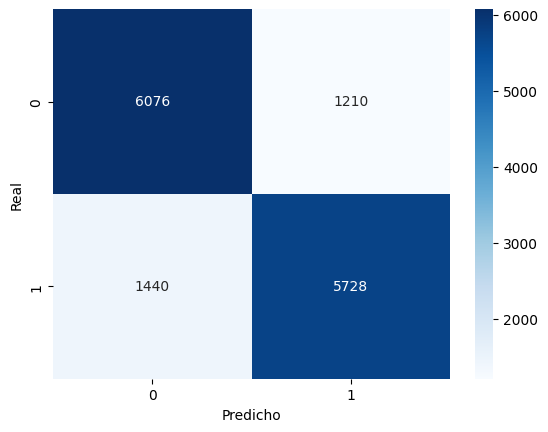


****************************************

Metricas obtenidas con el dataset: train_final

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      7286
           1       0.81      0.79      0.80      7168

    accuracy                           0.81     14454
   macro avg       0.81      0.81      0.81     14454
weighted avg       0.81      0.81      0.81     14454



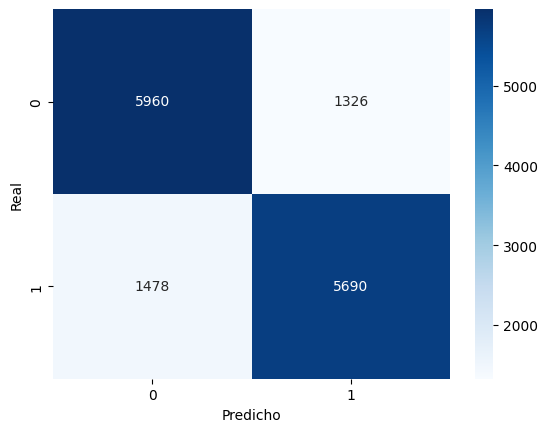


****************************************



In [ ]:
for dataset in datasets_train:

  # Cargo los datos para entrenar mi modelo
  x_train_xgb, x_test_xgb, y_train_xgb, y_test_xgb = generar_datos_para_test(dataset)

  # La implementación que usamos de XGBoost no soporta las etiquetas positivo/negativo, asi que las transformamos en 1 y 0.
  y_train_xgb = y_train_xgb.map(lambda x: 1 if x == 'negativo' else 0)
  y_test_xgb = y_test_xgb.map(lambda x: 1 if x == 'negativo' else 0)

  # Separo los mejores parametros
  mejores_parametros = mejores_parametros_xgb[dataset]
  parametros_xgb = {key: value for key, value in mejores_parametros.items() if key.startswith('xgbclassifier__')}
  parametros_tfidf = {key.replace('tfidfvectorizer__', ''): value for key, value in mejores_parametros.items() if key.startswith('tfidfvectorizer__')}

  # Creamos el modelo (Tuve que asignarle los parametros "a mano" a xgb porque no los tomaba con set_params)
  modelo_xgb = make_pipeline(TfidfVectorizer(**parametros_tfidf),
                             xgb.XGBClassifier(random_state=23,
                                               max_depth = parametros_xgb['xgbclassifier__max_depth'],
                                               learning_rate = parametros_xgb['xgbclassifier__learning_rate'],
                                               reg_alpha = parametros_xgb['xgbclassifier__reg_alpha'],
                                               reg_lambda = parametros_xgb['xgbclassifier__reg_lambda'],
                                               n_estimators=parametros_xgb['xgbclassifier__n_estimators'])
                             )

  # Entrenamos el modelo
  modelo_xgb.fit(x_train_xgb.texto_codificado, y_train_xgb)

  # Realizamos la predicción
  y_pred_xgb = modelo_xgb.predict(x_test_xgb.texto_codificado)

  # Mostramos los resultados obtenidos.
  mostrar_metricas(y_test_xgb, y_pred_xgb, dataset)

  # Predecimos con el modelo contra el set de pruebas que nos dieron.
  y_pred_xgb = modelo_xgb.predict(df_test.review_es)

  # Guardamos los resultados obtenidos
  ds_resultados = pd.DataFrame({'id': df_test["ID"], "sentimiento": y_pred_xgb})
  ds_resultados["sentimiento"] = ds_resultados["sentimiento"].map({0: "positivo", 1: "negativo"})
  ruta_resultados = ruta + "resultados/" + "resultados_xgb_optimizado_" + dataset + ".csv"

  # Solo si estoy trabajando localmente o en mi drive.
  if ruta == "" or "/content/drive" in ruta:
    ds_resultados.to_csv(ruta_resultados, index=False)

  # Guardamos el modelo entrenado
  ruta_modelo = ruta + "modelos/" + "modelo_xgb_optimizado_" + dataset + ".joblib"

  # Solo si estoy trabajando localmente o en mi drive.
  if ruta == "" or "/content/drive" in ruta:
    dump(modelo_xgb, ruta_modelo)

### 2.5. Modelo 4 - Red Neuronal

Todo el proceso de limpieza que requieren las redes neuronales para trabajar ya lo realizamos antes. En esta seccion solo vamos a trabajar con los datasets train_tokenizado y train_final.

Ademas, vamos a tokenizar el conjunto de test para que nuestra red neuronal pueda procesarlo.

Tokenizamos el conjunto de test y guardamos el dataset tokenizado.

In [ ]:
# Tokenizamos el conjunto de test
df_test = pd.read_csv(ruta + "datasets/test.csv")
df_test["texto_codificado"] = df_test["review_es"].apply(tokenizar_y_limpiar_texto)
df_test["texto_codificado"].head(5)

In [ ]:
# Solo si estoy trabajando localmente o en mi drive.
if ruta == "" or "/content/drive" in ruta:
    df_test.to_csv(ruta + "datasets/test_tokenizado.csv", index=False)

Definimos los datasets con los que vamos a trabajar

In [9]:
# Hago un listado de mis datasets para probarlos todos contra mis modelos.
datasets_train = ["train_tokenizado", "train_final"]

"""
* train_reducido ==> Dataset base, se le elimino la columna ID y la columna review_es se reemplazo por texto_codificado
* train_limpio ==> Se formateo el texto y se eliminaron las criticas en otros idiomas.
* train_lematizado ==> Se partio de train_limpio y se lematizo el texto.
* train_tokenizado ==> Se partio de train_limpio y se tokenizo el texto y se eliminaron las stopwords
* train_final ==> Se partio de train_lematizado y se tokenizo el texto y se eliminaron las stopwords

En esta sección solo utilizados los datasets train_tokenizado y train_final, dado que necesitamos que nuestros datos esten tokenizados
para que los pueda procesar la red neuronal.
"""

'\n* train_reducido ==> Dataset base, se le elimino la columna ID y la columna review_es se reemplazo por texto_codificado\n* train_limpio ==> Se formateo el texto y se eliminaron las criticas en otros idiomas.\n* train_lematizado ==> Se partio de train_limpio y se lematizo el texto.\n* train_tokenizado ==> Se partio de train_limpio y se tokenizo el texto y se eliminaron las stopwords\n* train_final ==> Se partio de train_lematizado y se tokenizo el texto y se eliminaron las stopwords\n'

In [16]:
# Funcion para crear la red.
def crear_modelo_red(embed_size=128,
                     gru_units=128,
                     dropout_rate=0.2,
                     learning_rate=0.001,
                     activation="sigmoid",
                     vocab_size=15000):

    modelo_red = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embed_size),
        GRU(gru_units, return_sequences=True),
        GRU(gru_units),
        Dropout(dropout_rate),
        Dense(1, activation=activation)
    ])

    modelo_red.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return modelo_red

#### 2.5.1 Red Neuronal basica

Vamos a definir un vocabulario que utilizaremos para entrenar nuestra red. Es necesario reducir la cantidad de palabras que tendra el mismo, ya que esta va a ser la cantidad de neuronas en nuestra entrada y una red neuronal con muchas neuronas no es eficiente.

Tokenizamos las reseñas y extraemos las palabras mas importantes

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         1920000   
                                                                 
 gru_10 (GRU)                (None, None, 128)         99072     
                                                                 
 gru_11 (GRU)                (None, 128)               99072     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,118,273
Trainable params: 2,118,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
1054/1054 [=======================

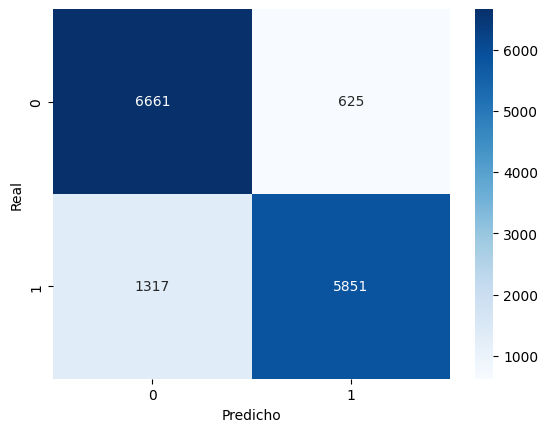


****************************************

269/269 [==============================] - 35s 131ms/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 128)         1920000   
                                                                 
 gru_12 (GRU)                (None, None, 128)         99072     
                                                                 
 gru_13 (GRU)                (None, 128)               99072     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,118,273
Trainable params: 2,118,273
Non-trainable params: 0
_________

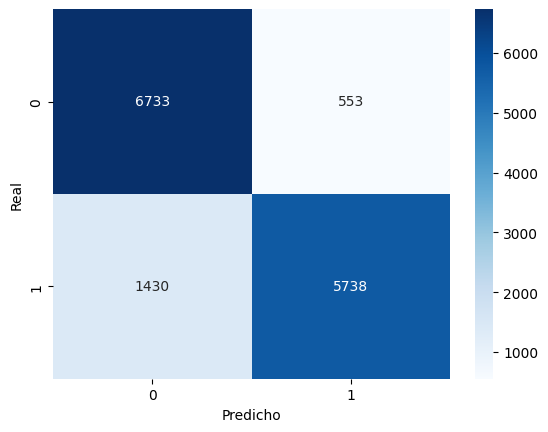


****************************************

269/269 [==============================] - 29s 109ms/step


In [17]:
# Establecemos una semilla aleatoria para TensorFlow y numpy
np.random.seed(23)
tf.random.set_seed(23)

for dataset in datasets_train:

    # ************************************************
    # ** 1- PREPARACIÓN DE LOS DATOS PARA TRABAJAR ***
    # ************************************************

    # Cargamos nuestros datasets
    df_train = pd.read_csv(ruta + "datasets/" + dataset + ".csv")
    df_test = pd.read_csv(ruta + "datasets/test_tokenizado.csv")

    # Obtenemos las secuencias de tokens para entrenamiento y prueba
    criticas_train = df_train["texto_codificado"].tolist()
    criticas_test = df_test["texto_codificado"].tolist()

    # Armo y entreno mi tokenizador.
    max_words = 15000
    tokenizador = Tokenizer(num_words=max_words)
    tokenizador.fit_on_texts(criticas_train)

    # Convertir textos a secuencias de enteros
    secuencia_train = tokenizador.texts_to_sequences(criticas_train)
    secuencia_test = tokenizador.texts_to_sequences(criticas_test)

    # Padding de las secuencias
    max_longitud_secuencia = 500
    train_padded = pad_sequences(secuencia_train, maxlen=max_longitud_secuencia)
    test_padded = pad_sequences(secuencia_test, maxlen=max_longitud_secuencia)

    # Cargo los datos para entrenar mi modelo
    x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(train_padded,
                                                                        df_train["sentimiento"],
                                                                        test_size = 0.30,
                                                                        random_state = 9,
                                                                        shuffle = True
                                                                        )

    # La implementación que usamos de Redes Neuronales no soporta las etiquetas positivo/negativo,
    # asi que las transformamos en 1 y 0.
    y_train_red = y_train_red.map(lambda x: 1 if x == 'negativo' else 0)
    y_test_red = y_test_red.map(lambda x: 1 if x == 'negativo' else 0)


    # ************************************************
    # ***** 2. ARMADO Y ENTRENAMIENTO DEL MODELO *****
    # ************************************************

    # Creacion de la red
    embed_size = 128
    vocab_size = max_words

    modelo_red = keras.models.Sequential([
        keras.layers.Embedding(vocab_size, embed_size, input_shape=[None]),
        keras.layers.GRU(128, return_sequences=True),
        keras.layers.GRU(128),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    modelo_red.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss = 'binary_crossentropy',
        metrics = ['f1_score']
    )

    modelo_red.summary()

    # Entrenamos el modelo
    modelo_red.fit(x_train_red, y_train_red, epochs = 4)

    # Predecimos con el modelo contra el set que me arme de pruebas
    # y_pred_proba es un array que contiene las probabilidades predichas por el modelo para los datos de prueba (x_test_red)
    y_pred_red_proba = modelo_red.predict(x_test_red)

    # Si y_pred_proba[i] > 0.5, el valor correspondiente en y_pred[i] será 1.
    # Si y_pred_proba[i] <= 0.5, el valor correspondiente en y_pred[i] será 0.
    y_pred_red = np.where(y_pred_red_proba > 0.5, 1, 0)

    # Mostramos los resultados obtenidos.
    mostrar_metricas(y_test_red, y_pred_red, dataset)


    # *************************************************
    # *** 3. PRUEBA DEL MODELO CONTRA DATOS DE TEST ***
    # *************************************************

    # Predecimos con el modelo contra el set de pruebas que nos dieron.
    # y_pred_proba es un array que contiene las probabilidades predichas por el modelo para los datos de prueba (test_padded)
    y_pred_red_proba = modelo_red.predict(test_padded)

    # Si y_pred_proba[i] > 0.5, el valor correspondiente en y_pred[i] será 1.
    # Si y_pred_proba[i] <= 0.5, el valor correspondiente en y_pred[i] será 0.
    y_pred_red = np.where(y_pred_red_proba > 0.5, 1, 0)

    # Guardamos los resultados obtenidos
    ds_resultados = pd.DataFrame({'id': df_test["ID"], "sentimiento": y_pred_red.ravel()})
    ds_resultados["sentimiento"] = ds_resultados["sentimiento"].map({0: "positivo", 1: "negativo"})
    ruta_resultados = ruta + "resultados/" + "resultados_red_basico_" + dataset + ".csv"

    # Solo si estoy trabajando localmente o en mi drive.
    if ruta == "" or "/content/drive" in ruta:
        ds_resultados.to_csv(ruta_resultados, index=False)

    # Guardamos el modelo entrenado
    ruta_modelo = ruta + "modelos/" + "modelo_red_basico_" + dataset + ".joblib"

    # Solo si estoy trabajando localmente o en mi drive.
    if ruta == "" or "/content/drive" in ruta:
        dump(modelo_red, ruta_modelo)

#### 2.5.2. Red Neuronal con mejores hiperparametros

Buscamos los mejores hiperparametros para cada dataset que obtuvimos al realizar el preprocesado.

In [10]:
# Establecemos una semilla aleatoria para numpy y tensorflow
np.random.seed(23)
tf.random.set_seed(23)

In [11]:
# Funcion para crear la red.
def crear_modelo_red(embed_size=128,
                     gru_units=128,
                     dropout_rate=0.2,
                     learning_rate=0.001,
                     activation="sigmoid",
                     vocab_size=15000):

    modelo_red = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embed_size),
        GRU(gru_units, return_sequences=True),
        GRU(gru_units),
        Dropout(dropout_rate),
        Dense(1, activation=activation)
    ])

    modelo_red.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return modelo_red


In [13]:
# Definimos la grilla de parametros
grilla_de_parametros_red = {
    "embed_size": [64, 128, 256],
    "gru_units": [64, 128, 256],
    "dropout_rate": [0.1, 0.2, 0.3],
    "learning_rate": [0.001, 0.01, 0.1],
    "activation": ["sigmoid", "relu", "softmax", "softplus", "elu"]
    }

# Envolvemos el modelo con KerasClassifier
modelo_red = KerasClassifier(build_fn=crear_modelo_red, epochs=4, verbose=1)

# Definimos el número de iteraciones y la cantidad de splits para la validación cruzada
n_iter = 10
cantidad_folds = 5

# Definimos la búsqueda aleatoria de hiperparámetros
randomcv = RandomizedSearchCV(estimator = modelo_red,
                              param_distributions = grilla_de_parametros_red,
                              n_iter = n_iter,
                              scoring='f1',
                              cv = cantidad_folds,
                              n_jobs = -1,
                              random_state=23)

# Diccionario donde voy a guardar los mejores parametros.
mejores_parametros_red = {}

# Ejecuta la búsqueda aleatoria de hiperparámetros en cada dataset
for dataset in datasets_train:

    # Carga el dataset
    df_train = pd.read_csv(ruta + "datasets/" + dataset + ".csv")
    
    # Preprocesamiento de datos
    criticas_train = df_train["texto_codificado"].tolist()

    max_words = 15000
    tokenizador = Tokenizer(num_words=max_words)
    tokenizador.fit_on_texts(criticas_train)

    secuencia_train = tokenizador.texts_to_sequences(criticas_train)
    max_longitud_secuencia = 500
    train_padded = pad_sequences(secuencia_train, maxlen=max_longitud_secuencia)

    x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(train_padded,
                                                                        df_train["sentimiento"],
                                                                        test_size=0.30,
                                                                        random_state=9,
                                                                        shuffle=True)

    y_train_red = y_train_red.map(lambda x: 1 if x == 'negativo' else 0)

    # Buscamos los mejores hiperparametros.
    randomcv.fit(x_train_red, y_train_red)

    # Imprime los mejores parámetros y la mejor métrica encontrada
    print(f"\nMejores parametros en Red Neuronal para el dataset: {dataset}\n")
    print("Mejor F1 Score:", randomcv.best_score_)
    mejores_parametros_red[dataset] = randomcv.best_params_
    print("Mejores parámetros:", mejores_parametros_red[dataset])
    print("\n******************************************\n")

C:\Users\fprat\AppData\Local\Temp\ipykernel_10776\1932616233.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  modelo_red = KerasClassifier(build_fn=crear_modelo_red, epochs=4, verbose=1)


Epoch 1/4
1054/1054 [==============================] - 192s 180ms/step - loss: 0.7249 - accuracy: 0.6940
Epoch 2/4
1054/1054 [==============================] - 190s 181ms/step - loss: 0.6263 - accuracy: 0.7784
Epoch 3/4
1054/1054 [==============================] - 190s 180ms/step - loss: 0.8072 - accuracy: 0.7381
Epoch 4/4
1054/1054 [==============================] - 190s 180ms/step - loss: 0.9675 - accuracy: 0.7029

Mejores parametros en Red Neuronal para el dataset: train_tokenizado

Mejor F1 Score: 0.767858679135402
Mejores parámetros: {'learning_rate': 0.01, 'gru_units': 64, 'embed_size': 128, 'dropout_rate': 0.2, 'activation': 'softplus'}

******************************************

Epoch 1/4
1054/1054 [==============================] - 192s 178ms/step - loss: 0.7790 - accuracy: 0.6740
Epoch 2/4
1054/1054 [==============================] - 187s 178ms/step - loss: 0.9912 - accuracy: 0.6542
Epoch 3/4
1054/1054 [==============================] - 186s 177ms/step - loss: 1.1736 - accur

Ahora que ya tenemos los mejores parametros procedemos a armar nuestro modelo y ponerlo a prueba para cada uno de nuestros datasets

Epoch 1/4
1054/1054 [==============================] - 209s 196ms/step - loss: 1.7589 - accuracy: 0.5961
Epoch 2/4
1054/1054 [==============================] - 199s 188ms/step - loss: 0.8476 - accuracy: 0.7070
Epoch 3/4
1054/1054 [==============================] - 196s 186ms/step - loss: 0.8319 - accuracy: 0.7497
Epoch 4/4
452/452 [==============================] - 27s 59ms/step
Metricas obtenidas con el dataset: train_tokenizado

              precision    recall  f1-score   support

           0       0.66      0.96      0.78      7286
           1       0.92      0.50      0.65      7168

    accuracy                           0.73     14454
   macro avg       0.79      0.73      0.71     14454
weighted avg       0.79      0.73      0.71     14454



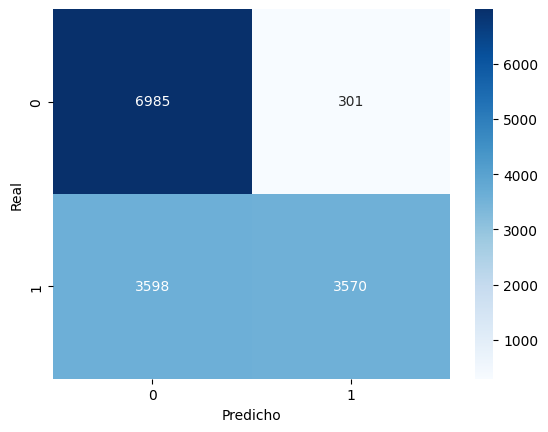


****************************************

269/269 [==============================] - 16s 58ms/step
Epoch 1/4
1054/1054 [==============================] - 203s 190ms/step - loss: 0.8730 - accuracy: 0.6924
Epoch 2/4
1054/1054 [==============================] - 203s 193ms/step - loss: 0.8985 - accuracy: 0.7070
Epoch 3/4
1054/1054 [==============================] - 202s 192ms/step - loss: 0.6926 - accuracy: 0.7148
Epoch 4/4
452/452 [==============================] - 24s 53ms/step
Metricas obtenidas con el dataset: train_final

              precision    recall  f1-score   support

           0       0.51      1.00      0.67      7286
           1       0.91      0.00      0.01      7168

    accuracy                           0.51     14454
   macro avg       0.71      0.50      0.34     14454
weighted avg       0.71      0.51      0.34     14454



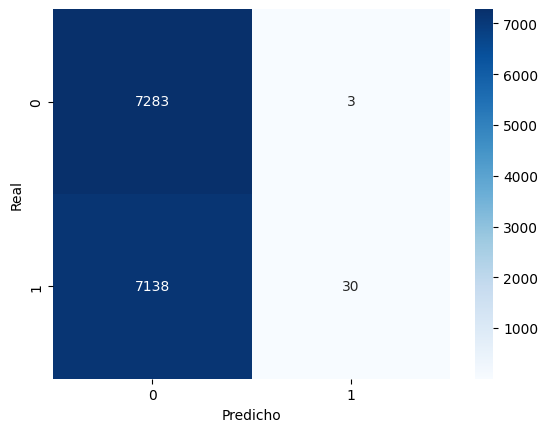


****************************************

269/269 [==============================] - 14s 54ms/step


In [14]:
for dataset in datasets_train:

  # ************************************************
  # ** 1- PREPARACIÓN DE LOS DATOS PARA TRABAJAR ***
  # ************************************************

  # Cargamos nuestros datasets
  df_train = pd.read_csv(ruta + "datasets/" + dataset + ".csv")
  df_test = pd.read_csv(ruta + "datasets/test_tokenizado.csv")

  # Obtenemos las secuencias de tokens para entrenamiento y prueba
  criticas_train = df_train["texto_codificado"].tolist()
  criticas_test = df_test["texto_codificado"].tolist()

  # Armo y entreno mi tokenizador.
  max_words = 15000
  tokenizador = Tokenizer(num_words=max_words)
  tokenizador.fit_on_texts(criticas_train)

  # Convertir textos a secuencias de enteros
  secuencia_train = tokenizador.texts_to_sequences(criticas_train)
  secuencia_test = tokenizador.texts_to_sequences(criticas_test)

  # Padding de las secuencias
  max_longitud_secuencia = 500
  train_padded = pad_sequences(secuencia_train, maxlen=max_longitud_secuencia)
  test_padded = pad_sequences(secuencia_test, maxlen=max_longitud_secuencia)

  # Cargo los datos para entrenar mi modelo
  x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(train_padded,
                                                                      df_train["sentimiento"],
                                                                      test_size = 0.30,
                                                                      random_state = 9,
                                                                      shuffle = True
                                                                      )

  # La implementación que usamos de Redes Neuronales no soporta las etiquetas positivo/negativo,
  # asi que las transformamos en 1 y 0.
  y_train_red = y_train_red.map(lambda x: 1 if x == 'negativo' else 0)
  y_test_red = y_test_red.map(lambda x: 1 if x == 'negativo' else 0)


  # ************************************************
  # ***** 2. ARMADO Y ENTRENAMIENTO DEL MODELO *****
  # ************************************************

  # Creacion de la red
  modelo_red = crear_modelo_red(embed_size=mejores_parametros_red[dataset]["embed_size"],
                                gru_units=mejores_parametros_red[dataset]["gru_units"],
                                dropout_rate=mejores_parametros_red[dataset]["dropout_rate"],
                                learning_rate=mejores_parametros_red[dataset]["learning_rate"],
                                activation=mejores_parametros_red[dataset]["activation"])

  # Entrenamos el modelo
  modelo_red.fit(x_train_red, y_train_red, epochs = 4)

  # Predecimos con el modelo contra el set que me arme de pruebas
  # y_pred_proba es un array que contiene las probabilidades predichas por el modelo para los datos de prueba (x_test_red)
  y_pred_red_proba = modelo_red.predict(x_test_red)

  # Si y_pred_proba[i] > 0.5, el valor correspondiente en y_pred[i] será 1.
  # Si y_pred_proba[i] <= 0.5, el valor correspondiente en y_pred[i] será 0.
  y_pred_red = np.where(y_pred_red_proba > 0.5, 1, 0)

  # Mostramos los resultados obtenidos.
  mostrar_metricas(y_test_red, y_pred_red, dataset)


  # *************************************************
  # *** 3. PRUEBA DEL MODELO CONTRA DATOS DE TEST ***
  # *************************************************

  # Predecimos con el modelo contra el set de pruebas que nos dieron.
  # y_pred_proba es un array que contiene las probabilidades predichas por el modelo para los datos de prueba (test_padded)
  y_pred_red_proba = modelo_red.predict(test_padded)

  # Si y_pred_proba[i] > 0.5, el valor correspondiente en y_pred[i] será 1.
  # Si y_pred_proba[i] <= 0.5, el valor correspondiente en y_pred[i] será 0.
  y_pred_red = np.where(y_pred_red_proba > 0.5, 1, 0)

  # Guardamos los resultados obtenidos
  ds_resultados = pd.DataFrame({'id': df_test["ID"], "sentimiento": y_pred_red.ravel()})
  ds_resultados["sentimiento"] = ds_resultados["sentimiento"].map({0: "positivo", 1: "negativo"})
  ruta_resultados = ruta + "resultados/" + "resultados_red_optimizado_" + dataset + ".csv"

  # Solo si estoy trabajando localmente o en mi drive.
  if ruta == "" or "/content/drive" in ruta:
      ds_resultados.to_csv(ruta_resultados, index=False)

  # Guardamos el modelo entrenado
  ruta_modelo = ruta + "modelos/" + "modelo_red_optimizado_" + dataset + ".joblib"

  # Solo si estoy trabajando localmente o en mi drive.
  if ruta == "" or "/content/drive" in ruta:
      dump(modelo_red, ruta_modelo)

Si bien, por algun motivo desconocido, la red muestra unos resulados paupérrimos al trabajar contra los datos de test locales. Mostro un desempeño bastante aceptable al contrastarla contra los datos de la competencia de Kaggle. Igualmente consideramos que para el tiempo que llevo optimizar este modelo, no vale la pena el esfuerzo, considerando el buen desempeño que obtuvimos con el modelo sin optimizar.

2.6. Modelo 5 - Ensamble

Vease el archivo -> 7506R_TP2_GRUPO08_CHP1_ENTREGA_N2.ipynb